In [1]:
spark

# Part I: Preparing features for machine learning

## Importing the `lib`

In [2]:
import pyspark.sql.functions as F
import pyspark.sql.types as T

## Reading the `Recipes dataset`

In [3]:
dataset = 's3://fcc-spark-example/dataset/2023/recipes_dataset/epi_r.csv'

food = (
            spark
                .read
                .csv(dataset, inferSchema=True, header=True)
        )

In [4]:
# To avoid the warning around, the truncation of the string representation of the execution plan 
# It's important to note that this warning is for debugging and informational purposes. 
# Truncating the string representation doesn't affect the actual execution or functionality of your Spark application.

spark.conf.set("spark.sql.debug.maxToStringFields", "100")

In [5]:
print(food.count(), len(food.columns))
food.printSchema()

23/07/31 17:29:38 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


20057 680
root
 |-- title: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- calories: string (nullable = true)
 |-- protein: double (nullable = true)
 |-- fat: double (nullable = true)
 |-- sodium: double (nullable = true)
 |-- #cakeweek: double (nullable = true)
 |-- #wasteless: double (nullable = true)
 |-- 22-minute meals: double (nullable = true)
 |-- 3-ingredient recipes: double (nullable = true)
 |-- 30 days of groceries: double (nullable = true)
 |-- advance prep required: double (nullable = true)
 |-- alabama: double (nullable = true)
 |-- alaska: double (nullable = true)
 |-- alcoholic: double (nullable = true)
 |-- almond: double (nullable = true)
 |-- amaretto: double (nullable = true)
 |-- anchovy: double (nullable = true)
 |-- anise: double (nullable = true)
 |-- anniversary: double (nullable = true)
 |-- anthony bourdain: double (nullable = true)
 |-- aperitif: double (nullable = true)
 |-- appetizer: double (nullable = true)
 |-- apple: double (nullabl

## Standardizing `column` names

In [6]:
def sanitize_column_name(col_name):
    """
    Drops unwanted characters from the column name.
    Replaces spaces, dashes, slashes with underscores,
    and keeps only alphanumeric characters and underscores.
    """
    replacements = {
        " ": "_",
        "-": "_",
        "/": "_",
        "&": "and"
    }

    # Apply character replacements
    for char, replacement in replacements.items():
        col_name = col_name.replace(char, replacement)

    # Filter and join valid characters
    sanitized_name = "".join(char for char in col_name if char.isalnum() or char == "_")

    return sanitized_name

food = food.toDF(*[sanitize_column_name(col_name) for col_name in food.columns])

## EDA and Feature Engineering

In [7]:
for x in food.columns:
    food.select(x).summary().show(truncate=False)

+-------+---------------------------------------------------------------------------------+
|summary|title                                                                            |
+-------+---------------------------------------------------------------------------------+
|count  |20057                                                                            |
|mean   |null                                                                             |
|stddev |null                                                                             |
|min    |                Blistered-Chile–Pumpkin Seed Salsa "                             |
|25%    |null                                                                             |
|50%    |null                                                                             |
|75%    |null                                                                             |
|max    |Zuppa di Cavolo Nero, Cannellini, e Salsicce: Kale, White Bean, and Sau

+-------+------------------+
|summary|protein           |
+-------+------------------+
|count  |15891             |
|mean   |100.19911427852243|
|stddev |3840.1994345415883|
|min    |0.0               |
|25%    |3.0               |
|50%    |8.0               |
|75%    |27.0              |
|max    |236489.0          |
+-------+------------------+

+-------+------------------+
|summary|fat               |
+-------+------------------+
|count  |15869             |
|mean   |346.91247085512634|
|stddev |20456.106754746786|
|min    |0.0               |
|25%    |7.0               |
|50%    |17.0              |
|75%    |33.0              |
|max    |1722763.0         |
+-------+------------------+

+-------+-----------------+
|summary|sodium           |
+-------+-----------------+
|count  |15933            |
|mean   |6225.759618402059|
|stddev |333318.1925119231|
|min    |0.0              |
|25%    |80.0             |
|50%    |294.0            |
|75%    |709.0            |
|max    |2.767511E7   

### Identifying the binary columns from our data frame

In [8]:
import pandas as pd

pd.set_option("display.max_rows", 1000)

is_binary = (
                food.agg(
                    *[
                        (F.size(F.collect_set(col_name)) == 2).alias(col_name)
                        for col_name in food.columns
                     ]
                    )
                .toPandas()
            )

is_binary.unstack()

title                     0    False
rating                    0    False
calories                  0    False
protein                   0    False
fat                       0    False
sodium                    0    False
cakeweek                  0    False
wasteless                 0    False
22_minute_meals           0     True
3_ingredient_recipes      0     True
30_days_of_groceries      0     True
advance_prep_required     0     True
alabama                   0     True
alaska                    0     True
alcoholic                 0     True
almond                    0     True
amaretto                  0     True
anchovy                   0     True
anise                     0     True
anniversary               0     True
anthony_bourdain          0     True
aperitif                  0     True
appetizer                 0     True
apple                     0     True
apple_juice               0     True
apricot                   0     True
arizona                   0     True
a

In [9]:
is_binary.unstack()[is_binary.unstack() == True].count()

672

In [10]:
is_binary.unstack()[is_binary.unstack() == False].count()

8

### Resolving data mishandling incidents and creating our initial set of features

In [11]:
#there were two columns that were suspicious: cakeweek and wasteless.

In [12]:
#Identifying the distinct values for our two suspicious columns

(
    food.agg(*[F.collect_set(x) for x in ("cakeweek", "wasteless")])
    .show(1, False)
)

+-------------------------------+----------------------+
|collect_set(cakeweek)          |collect_set(wasteless)|
+-------------------------------+----------------------+
|[0.0, 1.0, 1188.0, 24.0, 880.0]|[0.0, 1439.0, 1.0]    |
+-------------------------------+----------------------+



In [13]:
( 
    food.where("cakeweek > 1.0 or wasteless > 1.0")
        .select("title", "rating", "wasteless", "cakeweek", food.columns[-1])
        .show(truncate=False)
)

+----------------------------------------------------------------+------------------------+---------+--------+------+
|title                                                           |rating                  |wasteless|cakeweek|turkey|
+----------------------------------------------------------------+------------------------+---------+--------+------+
|"Beet Ravioli with Pine Nut ""Goat Cheese"" Rosemary-Cream Sauce| Aged Balsamic Vinegar "|0.0      |880.0   |0.0   |
|"Seafood ""Cataplana"" with Saffron                             | Vermouth               |1439.0   |24.0    |0.0   |
|"""Pot Roast"" of Seitan                                        | Aunt Gloria-Style "    |0.0      |1188.0  |0.0   |
+----------------------------------------------------------------+------------------------+---------+--------+------+



In [14]:
# Keeping only the legit values for cakeweek and wasteless

food = food.where(
                    ( F.col("cakeweek").isin([0.0, 1.0]) | F.col("cakeweek").isNull() ) & 
                    ( F.col("wasteless").isin([0.0, 1.0]) | F.col("wasteless").isNull() )
                )

In [15]:
print(food.count(), len(food.columns))

20054 680


### Creating four top-level variables

In [16]:
# the column that contain the information unique to each record
IDENTIFIERS = ["title"]



# The column which we wish to predict 
TARGET_COLUMN = ["dessert"]

# Columns which contains continuos values 
CONTINUOUS_COLUMNS = [
                        "rating",
                        "calories",
                        "protein",
                        "fat",
                        "sodium"
                     ]

# Columns which contains binary values 
BINARY_COLUMNS = [ x for x in food.columns
                        if x not in CONTINUOUS_COLUMNS and x not in TARGET_COLUMN and x not in IDENTIFIERS
                 ]

### Removing useless records and filling the `null` values of the `binary features`

In our case, this means removing two types of records:

- Those where all the features are null
- Those where the target is null

In [17]:
# every column but the name of the recipe 
food = food.dropna(
                    how="all",
                    subset=[x for x in food.columns if x not in IDENTIFIERS],
                  )

# target column 
food = food.dropna(
                    subset=TARGET_COLUMN
                  )

# We lost 5 records 
print(food.count(), len(food.columns))

20049 680


### Setting a default value of 0.0 to every binary feature column

In [18]:
food = food.fillna(0.0, subset=BINARY_COLUMNS)

### Taking care of extreme values: Cleaning continuous columns

In [19]:
# because of some data misalignment, PySpark inferred the type of the rating and calories column as a string, 
# where they should have been numerical

# Non-numerical values in the `rating` and `calories` columns

from typing import Optional

@F.udf(T.BooleanType())
def is_a_number(value: Optional[str]) -> bool:
    if not value:
        return True
    try:
        _ = float(value)
    except ValueError:
        return False
    
    return True

(
    food.where(~is_a_number(F.col("rating")))
        .select(*CONTINUOUS_COLUMNS)
        .show()
)

+---------+------------+-------+----+------+
|   rating|    calories|protein| fat|sodium|
+---------+------------+-------+----+------+
| Cucumber| and Lemon "|   3.75|null|  null|
+---------+------------+-------+----+------+



In [20]:
# Casting the rating and calories columns into double

for column in ["rating", "calories"]:
    food = food.where(is_a_number(F.col(column)))
    food = food.withColumn(column, F.col(column).cast(T.DoubleType()))

print(food.count(), len(food.columns))

20048 680


In [21]:
# # Looking at the values in our continuous feature columns

summary_df = (
    food.select(*CONTINUOUS_COLUMNS)
    .summary(
            "mean",
            "stddev",
            "min",
            "1%",
            "5%",
            "50%",
            "95%",
            "99%",
            "max")
)

In [22]:
summary_df.show()

+-------+------------------+------------------+------------------+-----------------+-----------------+
|summary|            rating|          calories|           protein|              fat|           sodium|
+-------+------------------+------------------+------------------+-----------------+-----------------+
|   mean| 3.714460295291301|6324.0634571930705|100.17385283565179|346.9398083953107|6226.927244193346|
| stddev|1.3409187660508954| 359079.8369634018|3840.6809971287385|20458.04034412412| 333349.568037027|
|    min|               0.0|               0.0|               0.0|              0.0|              0.0|
|     1%|               0.0|              18.0|               0.0|              0.0|              1.0|
|     5%|               0.0|              62.0|               0.0|              0.0|              5.0|
|    50%|             4.375|             331.0|               8.0|             17.0|            294.0|
|    95%|               5.0|            1315.0|              75.0|       

In [23]:
# Extract the 99% value for each continuous feature column
maximum = {}

for col in CONTINUOUS_COLUMNS:
    value_99 = (
                 summary_df
                    .select(col)
                    .filter(summary_df["summary"] == "99%")
                    .collect()[0][col]
                )
    
    maximum[col] = float(value_99)

In [24]:
maximum

{'rating': 5.0,
 'calories': 3184.0,
 'protein': 171.0,
 'fat': 205.0,
 'sodium': 5661.0}

In [25]:
# # Imputing the average value for four continuous columns

for k, v in maximum.items():
    food = (
                food.withColumn(k, F.when(F.isnull(F.col(k)), F.col(k))
                                    .otherwise(F.least(F.col(k), F.lit(v)))
                               )
            )

In [26]:
# Checking after the change 
(
    food.select(*CONTINUOUS_COLUMNS)
    .summary(
            "mean",
            "stddev",
            "min",
            "1%",
            "5%",
            "50%",
            "95%",
            "99%",
            "max")
    .show()
)

+-------+------------------+------------------+------------------+-----------------+-----------------+
|summary|            rating|          calories|           protein|              fat|           sodium|
+-------+------------------+------------------+------------------+-----------------+-----------------+
|   mean| 3.714460295291301|475.33021591765004|20.112481903443065|26.80461363922854|576.5727558066541|
| stddev|1.3409187660508957|481.39423292212604|28.936898178976968|32.59034551837936|859.9056416902445|
|    min|               0.0|               0.0|               0.0|              0.0|              0.0|
|     1%|               0.0|              18.0|               0.0|              0.0|              1.0|
|     5%|               0.0|              62.0|               0.0|              0.0|              5.0|
|    50%|             4.375|             331.0|               8.0|             17.0|            294.0|
|    95%|               5.0|            1316.0|              75.0|       

### Weeding out the rare binary occurrence columns

In [27]:
inst_sum_of_binary_columns = [
                                F.sum(F.col(x)).alias(x) for x in BINARY_COLUMNS
                            ]

sum_of_binary_columns = (
                            food.select(*inst_sum_of_binary_columns).head().asDict()
                        )

num_rows = food.count()

too_rare_features = [ k 
                      for k, v in sum_of_binary_columns.items() 
                      if v < 10 or v > (num_rows - 10)
                    ]

len(too_rare_features) # => 167

print(too_rare_features)
# ['cakeweek', 'wasteless', '30_days_of_groceries',
# [...]
# 'yuca', 'cookbooks', 'leftovers']

BINARY_COLUMNS = list(set(BINARY_COLUMNS) - set(too_rare_features))

23/07/31 17:33:31 WARN DAGScheduler: Broadcasting large task binary with size 1496.2 KiB


['cakeweek', 'wasteless', '30_days_of_groceries', 'alabama', 'alaska', 'anthony_bourdain', 'apple_juice', 'arizona', 'aspen', 'atlanta', 'australia', 'beverly_hills', 'biscuit', 'boston', 'bran', 'brooklyn', 'brownie', 'buffalo', 'bulgaria', 'burrito', 'cambridge', 'camping', 'canada', 'caviar', 'chicago', 'chili', 'cobbler_crumble', 'columbus', 'cook_like_a_diner', 'cookbook_critic', 'costa_mesa', 'cranberry_sauce', 'crêpe', 'crme_de_cacao', 'cuba', 'cupcake', 'custard', 'dallas', 'denver', 'digestif', 'dominican_republic', 'dorie_greenspan', 'eau_de_vie', 'egg_nog', 'egypt', 'emeril_lagasse', 'england', 'entertaining', 'epi__ushg', 'epi_loves_the_microwave', 'flat_bread', 'frankenrecipe', 'freezer_food', 'friendsgiving', 'frittata', 'fritter', 'germany', 'grains', 'grand_marnier', 'granola', 'grappa', 'guam', 'haiti', 'hamburger', 'hawaii', 'healdsburg', 'hollywood', 'house_cocktail', 'houston', 'hummus', 'iced_coffee', 'idaho', 'illinois', 'indiana', 'iowa', 'israel', 'italy', 'jama

In [28]:
sum_of_binary_columns
# sorted(sum_of_binary_columns.items(), key=lambda item: item[1], reverse=True)

{'cakeweek': 6.0,
 'wasteless': 1.0,
 '22_minute_meals': 17.0,
 '3_ingredient_recipes': 27.0,
 '30_days_of_groceries': 7.0,
 'advance_prep_required': 109.0,
 'alabama': 3.0,
 'alaska': 2.0,
 'alcoholic': 835.0,
 'almond': 584.0,
 'amaretto': 39.0,
 'anchovy': 45.0,
 'anise': 116.0,
 'anniversary': 111.0,
 'anthony_bourdain': 2.0,
 'aperitif': 12.0,
 'appetizer': 1372.0,
 'apple': 666.0,
 'apple_juice': 6.0,
 'apricot': 269.0,
 'arizona': 8.0,
 'artichoke': 153.0,
 'arugula': 278.0,
 'asian_pear': 20.0,
 'asparagus': 207.0,
 'aspen': 1.0,
 'atlanta': 7.0,
 'australia': 7.0,
 'avocado': 273.0,
 'back_to_school': 202.0,
 'backyard_bbq': 938.0,
 'bacon': 587.0,
 'bake': 4413.0,
 'banana': 177.0,
 'barley': 50.0,
 'basil': 565.0,
 'bass': 90.0,
 'bastille_day': 30.0,
 'bean': 577.0,
 'beef': 811.0,
 'beef_rib': 56.0,
 'beef_shank': 14.0,
 'beef_tenderloin': 72.0,
 'beer': 112.0,
 'beet': 209.0,
 'bell_pepper': 767.0,
 'berry': 465.0,
 'beverly_hills': 1.0,
 'birthday': 193.0,
 'biscuit': 7.

In [29]:
len(BINARY_COLUMNS), len(too_rare_features) 

(506, 167)

## Feature creation and refinement

### Creating new features

In [30]:
# Creating new features that compute calories attributable to protein and fat
# There are 4 kcal per grams of protein and 9 kcal per grams of fat.

food = (
            food.withColumn("protein_ratio", F.round((F.col("protein") * 4) / F.col("calories"), 5))
                .withColumn("fat_ratio", F.round((F.col("fat") * 9) / F.col("calories"), 5))
       )

food = food.fillna(0.0, subset=["protein_ratio", "fat_ratio"])

CONTINUOUS_COLUMNS += ["protein_ratio", "fat_ratio"]

In [31]:
food.select(*CONTINUOUS_COLUMNS).show(5)

+------+--------+-------+----+------+-------------+---------+
|rating|calories|protein| fat|sodium|protein_ratio|fat_ratio|
+------+--------+-------+----+------+-------------+---------+
|   2.5|   426.0|   30.0| 7.0| 559.0|      0.28169|  0.14789|
| 4.375|   403.0|   18.0|23.0|1439.0|      0.17866|  0.51365|
|  3.75|   165.0|    6.0| 7.0| 165.0|      0.14545|  0.38182|
|   5.0|    null|   null|null|  null|          0.0|      0.0|
| 3.125|   547.0|   20.0|32.0| 452.0|      0.14625|  0.52651|
+------+--------+-------+----+------+-------------+---------+
only showing top 5 rows



### Removing highly correlated features

In [32]:
# Removing highly correlated features
# Assembling feature columns into a single Vector column

from pyspark.ml.feature import VectorAssembler

continuous_features = VectorAssembler(
                                        inputCols=CONTINUOUS_COLUMNS, outputCol="continuous_features"
                                    )

vector_food = food.select(CONTINUOUS_COLUMNS)

for col in CONTINUOUS_COLUMNS:
    
    # Vector columns cannot have null values (and they don’t make sense when computing correlation), so we remove them through a series of where()
    vector_food = vector_food.where(~F.isnull(F.col(col)))

vector_variable = continuous_features.transform(vector_food)
vector_variable.select("continuous_features").show(3, False)



+----------------------------------------------+
|continuous_features                           |
+----------------------------------------------+
|[2.5,426.0,30.0,7.0,559.0,0.28169,0.14789]    |
|[4.375,403.0,18.0,23.0,1439.0,0.17866,0.51365]|
|[3.75,165.0,6.0,7.0,165.0,0.14545,0.38182]    |
+----------------------------------------------+
only showing top 3 rows



In [33]:
# Creating a correlation matrix in PySpark
from pyspark.ml.stat import Correlation

correlation = Correlation.corr(vector_variable, "continuous_features")

correlation.printSchema()

root
 |-- pearson(continuous_features): matrix (nullable = false)



In [34]:
correlation_array = correlation.head()[0].toArray()

correlation_pd = pd.DataFrame(
                                correlation_array,
                                index=CONTINUOUS_COLUMNS,
                                columns=CONTINUOUS_COLUMNS,
                              )

In [35]:
correlation_pd

,rating,calories,protein,fat,sodium,protein_ratio,fat_ratio
rating,1.000000,0.102454,0.113533,0.111841,0.065225,0.094407,0.129939
calories,0.102454,1.000000,0.758112,0.917925,0.516856,0.164540,0.176553
protein,0.113533,0.758112,1.000000,0.665499,0.585270,0.600531,0.109348
fat,0.111841,0.917925,0.665499,1.000000,0.421966,0.125708,0.425424
sodium,0.065225,0.516856,0.585270,0.421966,1.000000,0.338541,0.033649
protein_ratio,0.094407,0.164540,0.600531,0.125708,0.338541,1.000000,0.024963
fat_ratio,0.129939,0.176553,0.109348,0.425424,0.033649,0.024963,1.000000


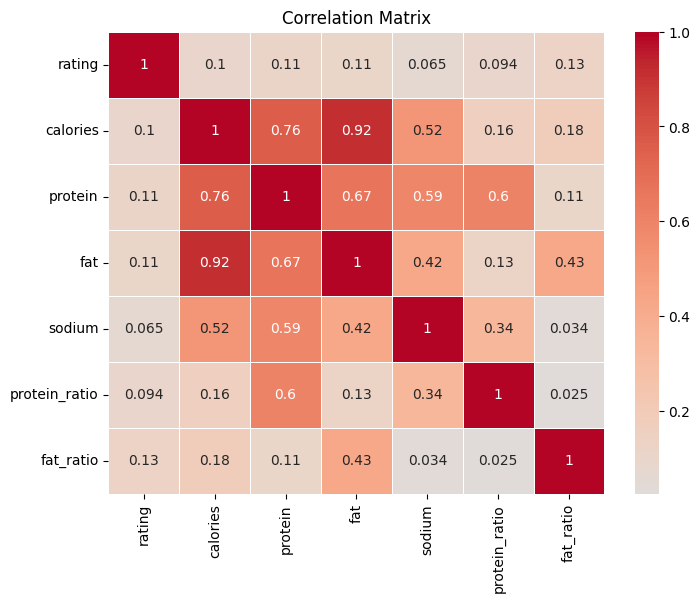

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a colorful correlation matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_pd, annot=True, cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

## Feature preparation with transformers and estimators

### Instantiating and applying the Imputer to create an ImputerModel

In [37]:
# Instantiating and applying the Imputer to create an ImputerModel

from pyspark.ml.feature import Imputer

OLD_COLS = ["calories", "protein", "fat", "sodium"]
NEW_COLS = ["calories_i", "protein_i", "fat_i", "sodium_i"]

imputer = Imputer(
                    strategy="mean",
                    inputCols=OLD_COLS,
                    outputCols=NEW_COLS,
                  )

imputer_model = imputer.fit(food)

CONTINUOUS_COLUMNS = (
                        list(set(CONTINUOUS_COLUMNS) - set(OLD_COLS)) + NEW_COLS
                     )

In [38]:
# Using the ImputerModel object just like a transformer

food_imputed = imputer_model.transform(food)
(
    food_imputed.where("calories is null")
                .select("calories", "calories_i")
                .show(5, False)

)

+--------+------------------+
|calories|calories_i        |
+--------+------------------+
|null    |475.33021591765004|
|null    |475.33021591765004|
|null    |475.33021591765004|
|null    |475.33021591765004|
|null    |475.33021591765004|
+--------+------------------+
only showing top 5 rows



### Scaling our features using the MinMaxScaler estimator

In [39]:
# Scaling our features using the MinMaxScaler estimator
# Scaling our nonscaled continuous variables

from pyspark.ml.feature import MinMaxScaler

CONTINUOUS_NB = [x 
                 for x in CONTINUOUS_COLUMNS 
                     if "ratio" not in x]

continuous_assembler = VectorAssembler(
                                            inputCols=CONTINUOUS_NB, 
                                            outputCol="continuous"
                                       )
food_features = continuous_assembler.transform(food_imputed)
continuous_scaler = MinMaxScaler(
                                    inputCol="continuous",
                                    outputCol="continuous_scaled",
                                )
food_features = (
                    continuous_scaler.fit(food_features)
                                 .transform(food_features)
                )


In [40]:
food_features.select("continuous_scaled").show(3, False)

+---------------------------------------------------------------------------------------+
|continuous_scaled                                                                      |
+---------------------------------------------------------------------------------------+
|[0.5,0.13379396984924624,0.17543859649122806,0.03414634146341464,0.09874580462815757]  |
|[0.875,0.12657035175879397,0.10526315789473684,0.11219512195121951,0.2541953718424307] |
|[0.75,0.05182160804020101,0.03508771929824561,0.03414634146341464,0.029146793852676208]|
+---------------------------------------------------------------------------------------+
only showing top 3 rows



# Part II: Building the ML Pipeline

So far we did the following:
    
- Read a CSV file containing dish names and multiple columns as feature
candidates
- 2 Sanitized the column names (lowered the case and fixed the punctuation,
spacing, and nonprintable characters)
- Removed illogical and irrelevant records
- Filled the null values of binary columns to 0.0
- Capped the amounts for calories, protein, fat, and sodium to the 99th percentile
- Created ratio features (number of calories from a macro over number of calories for the dish)
- Imputed the mean of continuous features
- Scaled continuous features between 0.0 and 1.0

## `Transformers` and `estimators`: The building blocks of ML in Spark

In simple terms, ML pipelines consist of two main components: transformers and estimators.

- `Transformers`: Think of transformers as reusable and customizable building blocks in the ML pipeline. They take data as input and transform it in a specific way. For example, a transformer might convert text into numbers or normalize data so that it's all in the same range. Transformers don't make predictions; instead, they modify the data to make it suitable for modeling.

- `Estimators`: Estimators are also building blocks in the ML pipeline, but they are responsible for creating and training ML models. When you train an ML model using an estimator, you get a fitted model, which is like a new program that we didn't write ourselves. This fitted model can then be used to make predictions on new data.

The ML pipeline is essentially an ordered list of transformers and estimators. You arrange these components in a specific sequence to prepare the data and build the model. The pipeline helps in creating a more structured and organized approach to ML tasks.

One of the significant advantages of using transformers and estimators is their portability. You can save the trained ML model and deploy it in different environments, making it easier to use the model in real-world applications.

Overall, transformers and estimators provide a useful abstraction for ML modeling, making it more efficient and facilitating the deployment of ML models in various settings.

To illustrate how a transformer and an estimator are parameterized, we will use a transformer and an estimator defined and used earlier:
- `continuous_assembler` — A **VectorAssembler transformer** that takes five columns and creates a Vector column to be used for model training
- `consinuous_scaler` — A **MinMaxScaler estimator** that scales values contained in a Vector column, returning values between 0 and 1 for each element in the vectors

## Building a (complete) machine learning pipeline

In this section, we build an ML pipeline with the estimators we used
for our dessert prediction feature preparation program and add the modeling step
in the mix.

In [41]:
from pyspark.ml import Pipeline
import pyspark.ml.feature as MF

imputer = MF.Imputer(  
                        strategy="mean",
                        inputCols=["calories", "protein", "fat", "sodium"],
                        outputCols=["calories_i", "protein_i", "fat_i", "sodium_i"],
                    )

continuous_assembler = MF.VectorAssembler(  
                                            inputCols=["rating", "calories_i", "protein_i", "fat_i", "sodium_i"],
                                            outputCol="continuous",
                                        )

continuous_scaler = MF.MinMaxScaler(  
                                      inputCol="continuous",
                                      outputCol="continuous_scaled",
                                    )

food_pipeline = Pipeline(  
                            stages=[imputer, continuous_assembler, continuous_scaler]
                        )

### Assembling the final data set with the vector column type

In [42]:
preml_assembler = MF.VectorAssembler(
                                        inputCols=BINARY_COLUMNS  
                                        + ["continuous_scaled"]
                                        + ["protein_ratio", "fat_ratio"],
                                        outputCol="features",
                                    )

food_pipeline.setStages(
                            [imputer, continuous_assembler, continuous_scaler, preml_assembler]
                        )

food_pipeline_model = food_pipeline.fit(food)  
food_features = food_pipeline_model.transform(food)  

Our data frame is ready for machine learning! We have a number of records, each with
- `A target (or label )` column, dessert, containing a binary input (1.0 if the recipe
is a dessert, 0.0 otherwise)
- `A vector of features`, called features, containing all the information we want to
train our machine learning model with

In [43]:
food_features.select("title", "dessert", "features").show(30, truncate=30)

# Since we have 513 elements in our vector, with a majority of zeroes, PySpark uses a sparse vector representation to save some space

+------------------------------+-------+------------------------------+
|                         title|dessert|                      features|
+------------------------------+-------+------------------------------+
|Lentil, Apple, and Turkey W...|    0.0|(513,[18,47,52,119,145,168,...|
|Boudin Blanc Terrine with R...|    0.0|(513,[7,108,151,205,279,308...|
| Potato and Fennel Soup Hodge |    0.0|(513,[16,134,172,251,343,40...|
|Mahi-Mahi in Tomato Olive S...|    0.0|(513,[36,43,106,121,130,194...|
|     Spinach Noodle Casserole |    0.0|(513,[11,251,286,296,308,33...|
|                The Best Blts |    0.0|(513,[47,122,168,221,260,27...|
|Ham and Spring Vegetable Sa...|    0.0|(513,[10,66,94,101,112,121,...|
|         Spicy-Sweet Kumquats |    0.0|(513,[15,119,151,343,373,38...|
|        Korean Marinated Beef |    0.0|(513,[61,82,94,209,343,379,...|
|Ham Persillade with Mustard...|    0.0|(513,[17,121,131,194,260,27...|
|Yams Braised with Cream, Ro...|    0.0|(513,[11,43,96,124,185,2

In [44]:
print(food_features.schema["features"])


StructField('features', VectorUDT(), True)


In [45]:
print(food_features.schema["features"].metadata) 

{'ml_attr': {'attrs': {'numeric': [{'idx': 0, 'name': 'tropical_fruit'}, {'idx': 1, 'name': 'cookies'}, {'idx': 2, 'name': 'edible_gift'}, {'idx': 3, 'name': 'oatmeal'}, {'idx': 4, 'name': 'blueberry'}, {'idx': 5, 'name': 'feta'}, {'idx': 6, 'name': 'crab'}, {'idx': 7, 'name': 'port'}, {'idx': 8, 'name': 'shrimp'}, {'idx': 9, 'name': 'phyllo_puff_pastry_dough'}, {'idx': 10, 'name': 'boil'}, {'idx': 11, 'name': 'fall'}, {'idx': 12, 'name': 'cranberry'}, {'idx': 13, 'name': 'trout'}, {'idx': 14, 'name': 'kale'}, {'idx': 15, 'name': 'cocktail_party'}, {'idx': 16, 'name': 'new_york'}, {'idx': 17, 'name': 'mustard'}, {'idx': 18, 'name': 'cookie'}, {'idx': 19, 'name': 'walnut'}, {'idx': 20, 'name': 'whiskey'}, {'idx': 21, 'name': 'roast'}, {'idx': 22, 'name': 'tapioca'}, {'idx': 23, 'name': 'ice_cream_machine'}, {'idx': 24, 'name': 'low_no_sugar'}, {'idx': 25, 'name': 'cherry'}, {'idx': 26, 'name': 'pernod'}, {'idx': 27, 'name': 'arugula'}, {'idx': 28, 'name': 'cocktail'}, {'idx': 29, 'name'

### Training an ML model using a `LogisticRegression` classifier

In [46]:
# Adding a LogisticRegression estimator to our pipeline

from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(
                            featuresCol="features", labelCol="dessert", predictionCol="prediction"
                        )

food_pipeline.setStages(
    [
        imputer,
        continuous_assembler,
        continuous_scaler,
        preml_assembler,
        lr, 
    ]
)

Pipeline_eac4f1fd943a

In [47]:
# Splitting our data frame for training and testing

train, test = food.randomSplit([0.7, 0.3], 13) 

train.cache()

food_pipeline_model = food_pipeline.fit(train)  
results = food_pipeline_model.transform(test) 


23/07/31 17:34:05 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/07/31 17:34:05 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


### Evaluating and optimizing our model

In [48]:
results.select("prediction", "rawPrediction", "probability").show(3, False)


+----------+--------------------------------------+-----------------------------------------+
|prediction|rawPrediction                         |probability                              |
+----------+--------------------------------------+-----------------------------------------+
|0.0       |[7.031830849514922,-7.031830849514922]|[0.9991174664674982,8.825335325017836E-4]|
|0.0       |[4.818496439125466,-4.818496439125466]|[0.9919858207866725,0.008014179213327477]|
|0.0       |[3.416675356885594,-3.416675356885594]|[0.9682216364268518,0.03177836357314823] |
+----------+--------------------------------------+-----------------------------------------+
only showing top 3 rows



In [49]:
# Creating a confusion matrix for our model using pivot() 
results.groupby("dessert").pivot("prediction").count().show()

+-------+----+---+
|dessert| 0.0|1.0|
+-------+----+---+
|    1.0|  97|963|
|    0.0|4957| 85|
+-------+----+---+



23/07/31 17:34:32 WARN DAGScheduler: Broadcasting large task binary with size 1000.8 KiB


In [50]:
# Computing the precision and recall (Spark 3.1+)
lr_model = food_pipeline_model.stages[-1]  
metrics = lr_model.evaluate(results.select("title", "dessert", "features"))

# LogisticRegressionTrainingSummary

print(f"Model precision: {metrics.precisionByLabel[1]}")  
print(f"Model recall: {metrics.recallByLabel[1]}")  

Model precision: 0.9188931297709924
Model recall: 0.9084905660377358


In [51]:
# Creating and evaluating a BinaryClassificationEvaluator object

from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(
    labelCol="dessert", 
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC",
)

accuracy = evaluator.evaluate(results)
print(f"Area under ROC = {accuracy} ")

Area under ROC = 0.9914685509643525 


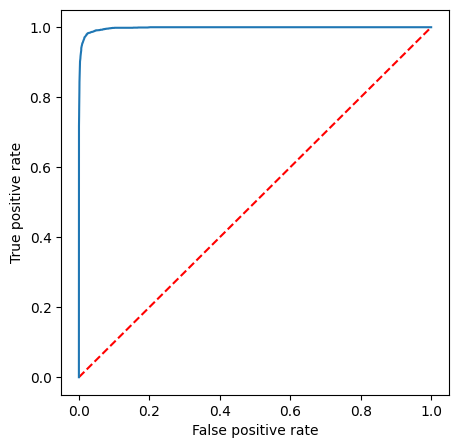

In [52]:
# Using matplotlib to display the ROC curve

plt.figure(figsize=(5, 5))
plt.plot([0, 1], [0, 1], "r--")
plt.plot(
        lr_model.summary.roc.select("FPR").collect(),
        lr_model.summary.roc.select("TPR").collect(),
    )
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.show()